In [1]:
import GSOM
import numpy as np
import matplotlib.pyplot as plt
import time
import networkx as nx
import itertools

In [3]:
dataset = np.load("data\small_scale.npy")
dataset = dataset * 1000

np.random.shuffle(dataset)


In [4]:
basis = GSOM.GSOM(dataset,0.94,0.10)

start_time = time.perf_counter() 
basis.train()
end_time = time.perf_counter()
print(f'Time training: {end_time-start_time}')


Growth Threshold = 0.12375080743617506
Weight Change 7.388952699246264e-06
Average error 0.05087907268408297
Max error 0.10636037796110469
Weights didn't change
Collapsing Triangle
Collapsing Triangle
Collapsing Triangle
Weight Change 0.0
Weights didn't change
Weight Change 0.0
Weights didn't change
Time training: 0.28981999994721264


Graph with 68 nodes and 67 edges
Triangles: 0.0


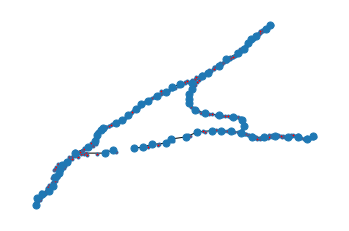

In [5]:
data = np.array(basis.data)

x_data = data[:,[0]] / 1000
y_data = data[:,[1]] / 1000
print(basis.network)
plt.plot(x_data, y_data, '.', markerfacecolor='red')


basis.print()
basis.visualizeGraph()

plt.show()

In [19]:
from scipy import spatial
import numba as nb
@nb.njit(fastmath=True)
def norm(l):
    s = 0.
    for i in range(l.shape[0]):
        s += l[i]**2
    return np.sqrt(s)

In [18]:
x = list(basis.network.nodes)
output_list = [i.array for i in x]


In [47]:
datapoint = np.random.rand(2).astype(np.float32)

start_time = time.perf_counter() 
for y in output_list:
    np.linalg.norm(y-datapoint)
end_time = time.perf_counter()
print(f'Numpy Lin Alg: {end_time-start_time}')

start_time = time.perf_counter() 
for y in output_list:
    norm(y-datapoint)
end_time = time.perf_counter()
print(f'Norm: {end_time-start_time}')


start_time = time.perf_counter() 
tree = spatial.cKDTree(output_list)
tree.query(datapoint,p=2)
end_time = time.perf_counter()
print(f'KDTree: {end_time-start_time}')


Numpy Lin Alg: 0.001065799966454506
Norm: 0.00030150008387863636
KDTree: 0.0005524000152945518


In [46]:

paths = dict(nx.all_pairs_shortest_path(basis.network))
c_segments = []
count = 0
nodes_j = []
for node,degree in list(basis.network.degree()):
    if degree == 1 or degree > 2:
        nodes_j.append(node)


for x1,x2 in itertools.combinations(nodes_j,2):
    flag = True
    if nx.has_path(basis.network,x1,x2):
        for y in paths[x1][x2][1:-1]:
            for z in nodes_j:
                if z == y:
                    flag = False
                    break
        if flag:
            c_segments.append(paths[x1][x2])
        count += 1
    

# c_segments = GSOM.findSegments(basis.network)

In [ ]:
print(len(c_segments))

40


In [ ]:
import osmnx as ox

G = ox.graph_from_bbox(34.2946,34.2739,-118.1399,-118.0957,network_type="all_private",truncate_by_edge=True)
print(G)
nx.draw(G,node_size=50)


MultiDiGraph with 10 nodes and 20 edges


In [ ]:

# min_lat = 40.6174
# max_lat = 40.6405
# min_long = -111.6501
# max_long = -111.6709



min_lat = 34.2739
max_lat = 34.2946
min_long = -118.0957
max_long = -118.1399






new_network = nx.Graph()
added = {}
input = G
i = 0
for u,v,data in input.edges(keys=False,data=True):
    if("geometry" not in data):
        print("here")
        continue
    i += 1
    if u not in added:
        lat = input.nodes[u]['y']
        long = input.nodes[u]['x']
        if lat < min_lat or lat > max_lat:
            continue
        if abs(long) < abs(min_long) or abs(long) > abs(max_long):
            continue
        n1 = GSOM.Node(np.array([lat,long], dtype=float))
        new_network.add_node(n1)
        added[u] = n1
    if v not in added:
        lat = input.nodes[v]['y']
        long = input.nodes[v]['x']
        if lat < min_lat or lat > max_lat:
            continue
        if abs(long) < abs(min_long) or abs(long) > abs(max_long):
            continue
        n2 = GSOM.Node(np.array([lat,long], dtype=float))
        new_network.add_node(n2)
        added[v] = n2

    polyline = list(data["geometry"].coords)

    # Construct new node and edge
    weights = np.array([polyline[0][1],polyline[0][0]],dtype=float)
    prev_node = GSOM.Node(weights)
    new_network.add_node(prev_node)

    # new_network.add_edge(added[v],prev_node,weight=1)


    for pair in list(data["geometry"].coords[1:]):
        weights = np.array([pair[1],pair[0]],dtype=float)
        new_node = GSOM.Node(weights)
        new_network.add_node(new_node)
        new_network.add_edge(new_node,prev_node,weight=1)  
        prev_node = new_node
    

    # new_network.add_edge(prev_node,added[u],weight=1)  


# Clean Data to inside bounding box
# 32.93127,32.92748,-117.17359,-117.17801

# for node in list(network.nodes):
#     lat = node.array[0]
#     long = node.array[1]
#     remove = False
#     if lat < min_lat or lat > max_lat:
#         remove = True
#     if abs(long) < abs(min_long) or abs(long) > abs(max_long):
#         remove = True
#     if remove:
#         network.remove_node(node)

        

pos_dict = {}
for node in new_network:
    pos_dict[node] = node.array

%matplotlib qt

edges,weights = zip(*nx.get_edge_attributes(new_network,"weight").items())
nx.draw(new_network,pos=pos_dict,node_size=50)



In [ ]:
# import GSOM 
# G_h = GSOM.convertGraph(ox.utils_graph.get_undirected(G))
# nx.draw(G_h,node_size=50)

# gt_segments = GSOM.findSegments(new_network)

paths = dict(nx.all_pairs_shortest_path(new_network))
segments = []
count = 0
nodes_j = []
for node,degree in list(new_network.degree()):
    if degree == 1 or degree > 2:
        nodes_j.append(node)


for x1,x2 in itertools.combinations(nodes_j,2):
    flag = True

    if nx.has_path(new_network,x1,x2):
        for y in paths[x1][x2][1:-1]:
            for z in nodes_j:
                if z == y:
                    flag = False
                    break
        if flag:
            segments.append(paths[x1][x2])
        count += 1
    
print(f"amount of segments {len(segments)}")




amount of segments 12


In [ ]:
def lineDistance(point,polyline):
    minDistance = float("inf")
    for node in polyline:
        distance = GSOM.distance(point.array,node.array)
        if distance < minDistance:
            minDistance = distance
    return minDistance

seg_dict = {}
match_dict = {}
for id_c,edge_c in enumerate(c_segments):
    minDistance = float("inf")
    for id_t,edge_t in enumerate(gt_segments):
        n = 0
        distanceSum = 0
        for point_c in edge_c:
            distanceSum += lineDistance(point_c,edge_t)
            n += 1
        segmentDistance = distanceSum / n
        if segmentDistance < minDistance:
            minDistance = segmentDistance
            seg_dict[id_c] = id_t


matched_length = 0
for x in seg_dict:
    segment = gt_segments[seg_dict[x]]
    for first,second in zip(segment,segment[1:]):
        matched_length += GSOM.distance(first.array,second.array)
print(matched_length)

total_length = 0
for segment in gt_segments:
    for first,second in zip(segment,segment[1:]):
        total_length += GSOM.distance(first.array,second.array)
print(total_length)
print(f"completeness {matched_length / total_length}")


AttributeError: 'numpy.ndarray' object has no attribute 'array'

In [ ]:

precisionArray = []
for id_c,edge_c in enumerate(c_segments):
    minDistance = float("inf")
    for id_t,edge_t in enumerate(gt_segments):
        n = 0
        distanceSum = 0
        for point_c in edge_c:
            distanceSum += lineDistance(point_c,edge_t)
            n += 1
        segmentDistance = distanceSum / n
        if segmentDistance < minDistance:
            minDistance = segmentDistance
    precisionArray.append(minDistance)
            

print(precisionArray)
print(f"Average: {np.mean(precisionArray)}")
print(f"Standard Deviation: {np.std(precisionArray)}")


# precisionArray[m] = distance between edge_c and edge_t_h
# return average and std of precisionArray

[0.00017988207184941807, 0.00010179636390198003, 6.369911445589677e-05, 0.00010603116821504126, 0.00017334990836540757, 0.00013842791212884603, 0.0001537524840779592]
Average: 0.00013099128899922126
Standard Deviation: 3.920919112923582e-05


In [ ]:
print(nx.convert_matrix.to_numpy_array(basis.network))
print(nx.convert_matrix.to_numpy_array(G_h))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]
